# Download the Data

In [2]:
!pip3 install tqdm
!pip3 install pillow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 29.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 10.0.1
    Uninstalling Pillow-10.0.1:
      Successfully uninstalled Pillow-10.0.1


In [2]:
import sys
print(sys.version)

3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]


In [96]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

# download_and_extract('data', '.')

# Visualize Data

In [97]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if (x[-3:] == 'png' and x[0] != '.')]
print(len(maps))

7390


In [98]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [99]:
images[0]
maps[0]

'Egyptian_Mau_73.png'

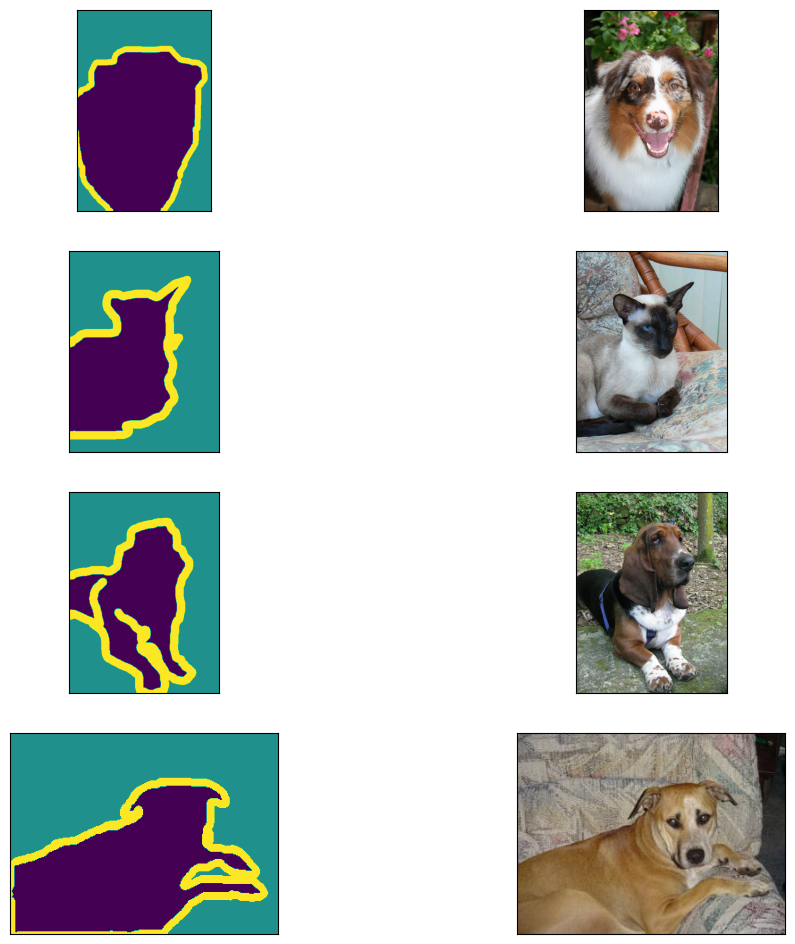

In [100]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [101]:
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


In [102]:
maps[0]

'Egyptian_Mau_73.png'

# SageMaker Setup

In [103]:
role = sagemaker.get_execution_role()
bucket_name = 'sagemaker-demo-petsdata'
training_image = get_image_uri(boto3.Session().region_name, 
                               'semantic-segmentation',
                              repo_version='latest')
print(training_image)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


825641698319.dkr.ecr.us-east-2.amazonaws.com/semantic-segmentation:1


In [104]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [105]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:14<00:00, 508.36it/s] 


In [92]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [20]:
print(len(train_annots), len(train_images))

5570 5570


# Uploading Data to S3

In [21]:
sess = sagemaker.Session()
print('Starting upload')
s3_train_path = sess.upload_data(path='train', 
                 bucket=bucket_name, 
                key_prefix='train')
print('Train upload successful')
s3_train_annotation_path = sess.upload_data(path='train_annotation', 
                 bucket=bucket_name, 
                key_prefix='train_annotation')
print('Train annotation upload successful')
s3_val_path = sess.upload_data(path='validation', 
                 bucket=bucket_name, 
                key_prefix='validation')
print('Validation upload successful')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation', 
                 bucket=bucket_name, 
                key_prefix='validation_annotation')
print('Validation annotation upload successful')

Starting upload
Train upload successful
Train annotation upload successful
Validation upload successful
Validation annotation upload successful


In [22]:
s3_validation_annotation_path

's3://sagemaker-demo-petsdata/validation_annotation'

# SageMaker Estimator

In [78]:
model = sagemaker.estimator.Estimator(
    training_image, #Docker image with model
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge', #GPU Instance for faster training
    volume_size=100, #100GB
    max_run=36000, #Maximum training time
    input_mode='File',
    output_path='s3://sagemaker-demo-petsdata/output', #Where will the model save
    sagemaker_session=sess
)

In [79]:
model

# Hyperparameters

In [80]:
model.set_hyperparameters(
    backbone='resnet-50',
    algorithm='fcn',
    use_pretrained_model=True,
    crop_size=240,
    num_classes=4,
    epochs=10,
    learning_rate=0.0001,
    optimizer='adam',
    lr_scheduler='poly',
    mini_batch_size=16,
    valudation_mini_batch_size=16,
    num_training_samples=len(train_images)    
)

# Data Channels

In [81]:
train_data = sagemaker.inputs.TrainingInput(s3_train_path, distribution='FullyReplicated',
                                       content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.inputs.TrainingInput(s3_val_path, distribution='FullyReplicated',
                                       content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation_data = sagemaker.inputs.TrainingInput(s3_train_annotation_path, distribution='FullyReplicated',
                                       content_type='image/png', s3_data_type='S3Prefix')
validation_annotation_data = sagemaker.inputs.TrainingInput(s3_validation_annotation_path, distribution='FullyReplicated',
                                       content_type='image/png', s3_data_type='S3Prefix')


In [82]:
data_channel = {
    'train': train_data,
    'validation': validation_data,
    'train_annotation': train_annotation_data,
    'validation_annotation': validation_annotation_data,
}

In [83]:
data_channel

{'train': <sagemaker.inputs.TrainingInput at 0x7fb279e2b6d0>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7fb279e2a950>,
 'train_annotation': <sagemaker.inputs.TrainingInput at 0x7fb2795ff310>,
 'validation_annotation': <sagemaker.inputs.TrainingInput at 0x7fb279e2b340>}

# Model Training

In [ ]:
model.fit(inputs=data_channel, logs=True)

# Deploy Model

In [ ]:
deployed_model = model.deploy(initial_instance_count=1, 
                              instance_type='ml.m4.xlarge')
print('\nModel deployed!')

# Predictions

In [ ]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

In [ ]:
deployed_model.content_type = 'image/jpeg'
deployed_model.accept = 'image/png'

In [ ]:
index = 2

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)

In [ ]:
mask = np.array(Image.open(io.BytesIO(results)))

In [ ]:
plt.imshow(plt.imread(image_path));

In [ ]:
plt.imshow(mask);

In [ ]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint) # Delete endpoint to avoid more cost.